In [1]:
# Setup

# Characters are represented by 1-hot vectors of size 128
char_dim = 128

import numpy as np
import os
from collections import Counter
import unicodedata
import string
import gc
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import LSTM
from torch import optim

In [2]:
# replaces special characters with their close equivalents in order to simplify the characters that appear
def clean_text(text):
    return str(unicodedata.normalize('NFD', text).encode('ascii', 'ignore')).replace('\\n', '\n')

file = open('beatles.txt', 'r')
beatleslyrics = ''
# ignore lines that consist of 'TOP'
line = file.readline()
while line != '':
    beatleslyrics += line
    line = file.readline()
file.close()
beatleslyrics = clean_text(beatleslyrics)
print('read %d characters' % len(beatleslyrics))
char_counter = Counter(beatleslyrics)
print(char_counter)

for key in char_counter.keys():
    if ord(key) >= 128:
        print('invalid character value found: %s has numeric value %d', key, ord(key))

read 142942 characters
Counter({' ': 24384, 'e': 13002, 'o': 9898, 't': 8128, 'n': 7393, 'a': 7361, '\n': 5725, 'h': 5718, 'l': 5473, 'i': 5456, 's': 4862, 'r': 4848, 'y': 4260, 'd': 3771, 'u': 3528, 'm': 3125, 'g': 2673, 'w': 2581, ',': 2026, 'I': 1938, 'b': 1810, 'c': 1681, '.': 1438, 'k': 1382, 'v': 1269, 'f': 1256, 'p': 1085, "'": 985, 'T': 559, 'S': 492, 'A': 481, 'W': 409, 'O': 339, 'P': 296, 'B': 293, 'Y': 277, 'H': 236, '-': 228, 'L': 210, 'D': 208, 'M': 199, 'C': 161, 'N': 143, 'j': 137, 'G': 132, '(': 117, ')': 117, 'E': 107, 'R': 106, '?': 101, 'F': 95, 'z': 72, 'J': 69, 'x': 69, '!': 48, 'K': 46, 'U': 30, 'q': 18, '9': 15, ']': 12, 'V': 10, ';': 9, '[': 9, '0': 9, 'Q': 5, '1': 4, '5': 3, '"': 2, '2': 2, '3': 2, '4': 2, '7': 2, ':': 2, '/': 1, '6': 1, '8': 1})


In [3]:
# converts a list of N strings of length <=T into a numpy array of 1-hot vectors
# input: list of length N; max length of any string in the list is T
# output size: (T, N, 128)
i128 = np.eye(128)
def char_to_ix(texts):
    T = max([len(text) for text in texts])
    ords = np.zeros((T, len(texts)), dtype=int)
    for n, text in enumerate(texts):
        ords[:len(text), n] = [ord(char) for char in text]
    return i128[ords]

# converts a list of N strings of length <=T into a numpy array of length (T, N).
# Zero-pads shorter strings.
def char_to_array(texts):
    T = max([len(text) for text in texts])
    result = np.zeros((T, len(texts)), dtype=int)
    for n, text in enumerate(texts):
        result[:len(text), n] = [ord(char) for char in text]
    return result
    #ords = np.array([[ord(char) for char in text] for text in texts], dtype=int)
    #return ords.transpose((1, 0))

In [5]:
# free some memory if possible
train_data = None
val_data = None
test_data = None
val_data_ix = None
val_data_array = None
test_data_ix = None
test_data_array = None
gc.collect()

train_data = ''
val_data = ''
test_data = ''

# the string TOP separates all songs
songs = beatleslyrics.split('TOP\n')
print('number of songs: %d' % len(songs))
np.random.seed(0)
np.random.shuffle(songs)

train_data = songs[:len(songs) * 34 // 100]
val_data   = songs[len(songs) * 34 // 100:len(songs) * 67 // 100]
test_data  = songs[len(songs) * 67 // 100:]

train_data_ix = torch.tensor(char_to_ix(train_data), dtype=torch.float)
train_data_array = torch.tensor(char_to_array(train_data))

print(train_data_ix.shape)
print(train_data_array.shape)

val_data_ix = torch.tensor(char_to_ix(val_data), dtype=torch.float)
val_data_array = torch.tensor(char_to_array(val_data))

test_data_ix = torch.tensor(char_to_ix(test_data), dtype=torch.float)
test_data_array = torch.tensor(char_to_array(test_data))

print(len(train_data))
print(len(val_data))
print(len(test_data))

number of songs: 181
torch.Size([1706, 61, 128])
torch.Size([1706, 61])
61
60
60


In [6]:
class BeatlesLSTM(nn.Module):
    def __init__(self, hidden_dim, num_stacks):
        super(BeatlesLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(char_dim, hidden_dim, num_layers=num_stacks, dropout=0.0)
        
        # The linear layer that maps from hidden state space to character space
        self.hidden2char = nn.Linear(hidden_dim, char_dim)
        self.init_hidden_zeros(1)
    
    def init_hidden_zeros(self, minibatch_size):
        self.init_hidden(torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)), torch.zeros((self.lstm.num_layers, minibatch_size, self.hidden_dim)))
    
    def init_hidden(self, h, c):
        self.hidden = (h, c)

    def forward(self, text):
        # text should be of size (T, N, char_dim)
        # returns character scores of size (T, N, char_dim)
        
        hs, self.hidden = self.lstm(text, self.hidden)
        char_space = self.hidden2char(hs)
        return char_space

In [7]:
def model_loss(model, loss_func, data_ix, data_array):
    model.lstm.eval()
    this_minibatch_size = data_ix.shape[1]
    model.init_hidden_zeros(this_minibatch_size)
    sequence_in = data_ix[:-1, :, :]
    #sequence_out = data_array[1:, :]

    #char_scores = model(sequence_in)
    #loss = loss_func(char_scores.view(-1, char_dim), sequence_out.view(-1))
    loss = 0
    with torch.no_grad():
        for i, char_in in enumerate(sequence_in):
            char_scores = model(char_in.view(1, this_minibatch_size, -1))
            loss += loss_func(char_scores.view(-1, char_dim), data_array[i+1,:])
    model.lstm.train()
    return loss / len(sequence_in)

In [9]:
def train_loop(model, epochs, train_data_ix, train_data_array, val_data_ix, val_data_array,
               checkpoint_name=None, minibatch_size=4):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters())
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print('on epoch %d' % epoch)
        for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
            print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
            model.zero_grad()

            sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
            sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]

            # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
            this_minibatch_size = sequence_in.shape[1]
            model.init_hidden_zeros(this_minibatch_size)

            char_scores = model(sequence_in)
            loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(gutenberg_model.parameters(), 5)
            optimizer.step()
        print()
        train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
        val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
        print('\ttraining loss = %f' % train_loss)
        print('\tvalidation loss = %f' % val_loss)
        train_losses += [train_loss]
        val_losses += [val_loss]
        if checkpoint_name != None:
            torch.save(model.state_dict(), checkpoint_name + str(epoch))
    return train_losses, val_losses

def freeze_all_but_layer(model, layer):
    count = 0
    for param in model.parameters():
        if count / 4 == layer:
            param.requires_grad = True
        else:
            param.requires_grad = False
        count += 1

def freeze_layer(model, layer):
    count = 0
    for param in model.parameters():
        if count // 4 == layer:
            param.requires_grad = False
        else:
            param.requires_grad = True
        count += 1

on epoch 0
	on iteration 14 / 15
	training loss = 1.928874
	validation loss = 2.081647
on epoch 1
	on iteration 14 / 15
	training loss = 1.471978
	validation loss = 1.611229
on epoch 2
	on iteration 14 / 15
	training loss = 1.275568
	validation loss = 1.402449
on epoch 3
	on iteration 14 / 15
	training loss = 1.182001
	validation loss = 1.303262
on epoch 4
	on iteration 14 / 15
	training loss = 1.091965
	validation loss = 1.209699
on epoch 5
	on iteration 14 / 15
	training loss = 1.051820
	validation loss = 1.169946
on epoch 6
	on iteration 14 / 15
	training loss = 1.019763
	validation loss = 1.143764
on epoch 7
	on iteration 14 / 15
	training loss = 0.998386
	validation loss = 1.125143
on epoch 8
	on iteration 14 / 15
	training loss = 0.978582
	validation loss = 1.109978
on epoch 9
	on iteration 14 / 15
	training loss = 0.959731
	validation loss = 1.096035
on epoch 10
	on iteration 14 / 15
	training loss = 0.935922
	validation loss = 1.083305
on epoch 11
	on iteration 14 / 15
	trainin

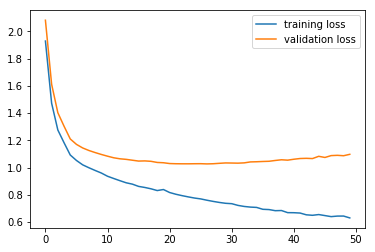

on epoch 0
	on iteration 14 / 15
	training loss = 1.702667
	validation loss = 1.865921
on epoch 1
	on iteration 14 / 15
	training loss = 1.569584
	validation loss = 1.725635
on epoch 2
	on iteration 14 / 15
	training loss = 1.594948
	validation loss = 1.754186
on epoch 3
	on iteration 14 / 15
	training loss = 1.513970
	validation loss = 1.665890
on epoch 4
	on iteration 14 / 15
	training loss = 1.435095
	validation loss = 1.582675
on epoch 5
	on iteration 14 / 15
	training loss = 1.370302
	validation loss = 1.512260
on epoch 6
	on iteration 14 / 15
	training loss = 1.282757
	validation loss = 1.414188
on epoch 7
	on iteration 14 / 15
	training loss = 1.231578
	validation loss = 1.358985
on epoch 8
	on iteration 14 / 15
	training loss = 1.188718
	validation loss = 1.313914
on epoch 9
	on iteration 14 / 15
	training loss = 1.158261
	validation loss = 1.283659
on epoch 10
	on iteration 14 / 15
	training loss = 1.123090
	validation loss = 1.248646
on epoch 11
	on iteration 14 / 15
	trainin

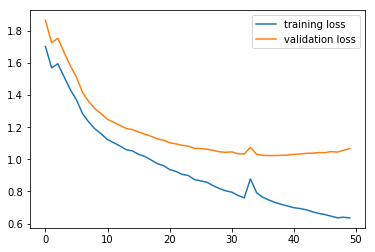

on epoch 0
	on iteration 14 / 15
	training loss = 2.290074
	validation loss = 2.463826
on epoch 1
	on iteration 14 / 15
	training loss = 2.288628
	validation loss = 2.464976
on epoch 2
	on iteration 14 / 15
	training loss = 2.271879
	validation loss = 2.445744
on epoch 3
	on iteration 14 / 15
	training loss = 2.260106
	validation loss = 2.428253
on epoch 4
	on iteration 14 / 15
	training loss = 2.256854
	validation loss = 2.424189
on epoch 5
	on iteration 14 / 15
	training loss = 2.257251
	validation loss = 2.420581
on epoch 6
	on iteration 14 / 15
	training loss = 2.250508
	validation loss = 2.413440
on epoch 7
	on iteration 14 / 15
	training loss = 2.776002
	validation loss = 3.042617
on epoch 8
	on iteration 14 / 15
	training loss = 2.268722
	validation loss = 2.442250
on epoch 9
	on iteration 14 / 15
	training loss = 2.261897
	validation loss = 2.432681
on epoch 10
	on iteration 14 / 15
	training loss = 2.258280
	validation loss = 2.427777
on epoch 11
	on iteration 14 / 15
	trainin

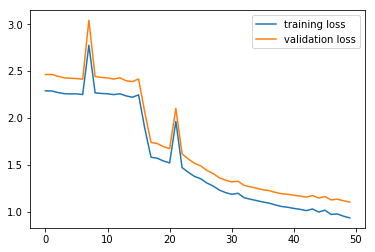

In [70]:
model = BeatlesLSTM(64, 1)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_1h = []
val_losses_1h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_1h += [train_loss]
    val_losses_1h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_1layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h, label='training loss')
plt.plot(ts, val_losses_1h, label='validation loss')
plt.legend(loc='best')
plt.show()

#######################################

model = BeatlesLSTM(64, 2)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_2h = []
val_losses_2h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_2h += [train_loss]
    val_losses_2h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_2layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h, label='training loss')
plt.plot(ts, val_losses_2h, label='validation loss')
plt.legend(loc='best')
plt.show()

########################################

model = BeatlesLSTM(64, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h = []
val_losses_3h = []
minibatch_size = 4

for epoch in range(50):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h += [train_loss]
    val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(50)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h, label='training loss')
plt.plot(ts, val_losses_3h, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 1.949551
	validation loss = 2.099774
on epoch 1
	on iteration 14 / 15
	training loss = 1.468565
	validation loss = 1.598758
on epoch 2
	on iteration 14 / 15
	training loss = 1.274842
	validation loss = 1.389922
on epoch 3
	on iteration 14 / 15
	training loss = 1.197866
	validation loss = 1.309799
on epoch 4
	on iteration 14 / 15
	training loss = 1.151923
	validation loss = 1.265468
on epoch 5
	on iteration 14 / 15
	training loss = 1.111867
	validation loss = 1.226555
on epoch 6
	on iteration 14 / 15
	training loss = 1.083662
	validation loss = 1.202559
on epoch 7
	on iteration 14 / 15
	training loss = 1.065781
	validation loss = 1.188047
on epoch 8
	on iteration 14 / 15
	training loss = 1.041975
	validation loss = 1.168543
on epoch 9
	on iteration 14 / 15
	training loss = 1.017253
	validation loss = 1.150066
on epoch 10
	on iteration 14 / 15
	training loss = 1.000239
	validation loss = 1.137983
on epoch 11
	on iteration 14 / 15
	trainin

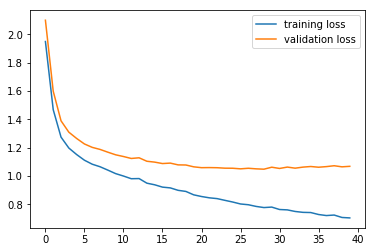

In [11]:
model = BeatlesLSTM(64, 1)
model.lstm.dropout = 0.2
train_losses_1h_dropout, val_losses_1h_dropout = train_loop(
        model, 40, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_beatles_h64s_1layer_dropout_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_1h_dropout))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h_dropout), np.argmin(val_losses_1h_dropout)))
plt.plot(ts, train_losses_1h_dropout, label='training loss')
plt.plot(ts, val_losses_1h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 1.677648
	validation loss = 1.825075
on epoch 1
	on iteration 14 / 15
	training loss = 1.567471
	validation loss = 1.708573
on epoch 2
	on iteration 14 / 15
	training loss = 1.421342
	validation loss = 1.552138
on epoch 3
	on iteration 14 / 15
	training loss = 1.361537
	validation loss = 1.488068
on epoch 4
	on iteration 14 / 15
	training loss = 1.297646
	validation loss = 1.416249
on epoch 5
	on iteration 14 / 15
	training loss = 1.228390
	validation loss = 1.347900
on epoch 6
	on iteration 14 / 15
	training loss = 1.190331
	validation loss = 1.308547
on epoch 7
	on iteration 14 / 15
	training loss = 1.159095
	validation loss = 1.278612
on epoch 8
	on iteration 14 / 15
	training loss = 1.134134
	validation loss = 1.255780
on epoch 9
	on iteration 14 / 15
	training loss = 1.116776
	validation loss = 1.239594
on epoch 10
	on iteration 14 / 15
	training loss = 1.096668
	validation loss = 1.221866
on epoch 11
	on iteration 14 / 15
	trainin

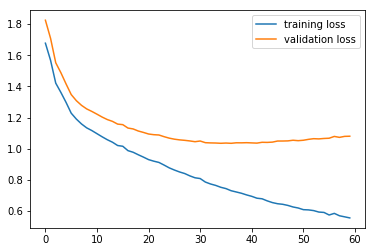

In [12]:
model = BeatlesLSTM(64, 2)
model.lstm.dropout = 0.2
train_losses_2h_dropout, val_losses_2h_dropout = train_loop(
        model, 60, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_beatles_h64s_2layer_dropout_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_2h_dropout))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h_dropout), np.argmin(val_losses_2h_dropout)))
plt.plot(ts, train_losses_2h_dropout, label='training loss')
plt.plot(ts, val_losses_2h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.267199
	validation loss = 2.424552
on epoch 1
	on iteration 14 / 15
	training loss = 2.273595
	validation loss = 2.432300
on epoch 2
	on iteration 14 / 15
	training loss = 2.265365
	validation loss = 2.422726
on epoch 3
	on iteration 14 / 15
	training loss = 2.238295
	validation loss = 2.396588
on epoch 4
	on iteration 14 / 15
	training loss = 2.194023
	validation loss = 2.342236
on epoch 5
	on iteration 14 / 15
	training loss = 1.903507
	validation loss = 2.051736
on epoch 6
	on iteration 14 / 15
	training loss = 1.653214
	validation loss = 1.801848
on epoch 7
	on iteration 14 / 15
	training loss = 1.590838
	validation loss = 1.734261
on epoch 8
	on iteration 14 / 15
	training loss = 1.580351
	validation loss = 1.723527
on epoch 9
	on iteration 14 / 15
	training loss = 1.577001
	validation loss = 1.720296
on epoch 10
	on iteration 14 / 15
	training loss = 1.574958
	validation loss = 1.718250
on epoch 11
	on iteration 14 / 15
	trainin

	on iteration 14 / 15
	training loss = 1.317981
	validation loss = 1.482355
on epoch 94
	on iteration 14 / 15
	training loss = 1.305637
	validation loss = 1.468578
on epoch 95
	on iteration 14 / 15
	training loss = 1.313702
	validation loss = 1.479737
on epoch 96
	on iteration 14 / 15
	training loss = 1.291187
	validation loss = 1.455045
on epoch 97
	on iteration 14 / 15
	training loss = 1.274219
	validation loss = 1.440783
on epoch 98
	on iteration 14 / 15
	training loss = 1.270517
	validation loss = 1.435871
on epoch 99
	on iteration 14 / 15
	training loss = 1.266127
	validation loss = 1.434175
on epoch 100
	on iteration 14 / 15
	training loss = 1.244990
	validation loss = 1.411659
on epoch 101
	on iteration 14 / 15
	training loss = 1.238555
	validation loss = 1.404148
on epoch 102
	on iteration 14 / 15
	training loss = 1.230941
	validation loss = 1.396221
on epoch 103
	on iteration 14 / 15
	training loss = 1.221799
	validation loss = 1.386898
on epoch 104
	on iteration 14 / 15
	trai

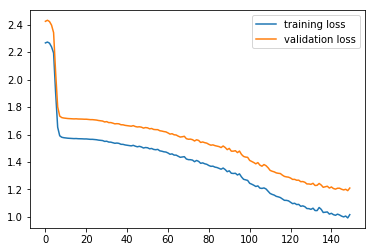

In [13]:
model = BeatlesLSTM(64, 3)
model.lstm.dropout = 0.2
train_losses_3h_dropout, val_losses_3h_dropout = train_loop(
        model, 150, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_beatles_h64s_3layer_dropout_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_3h_dropout))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h_dropout), np.argmin(val_losses_3h_dropout)))
plt.plot(ts, train_losses_3h_dropout, label='training loss')
plt.plot(ts, val_losses_3h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 1.906291
	validation loss = 2.072191
on epoch 1
	on iteration 14 / 15
	training loss = 1.359106
	validation loss = 1.481499
on epoch 2
	on iteration 14 / 15
	training loss = 1.205080
	validation loss = 1.320666
on epoch 3
	on iteration 14 / 15
	training loss = 1.112760
	validation loss = 1.228485
on epoch 4
	on iteration 14 / 15
	training loss = 1.074154
	validation loss = 1.195844
on epoch 5
	on iteration 14 / 15
	training loss = 1.034890
	validation loss = 1.161744
on epoch 6
	on iteration 14 / 15
	training loss = 0.996878
	validation loss = 1.133270
on epoch 7
	on iteration 14 / 15
	training loss = 0.969369
	validation loss = 1.114544
on epoch 8
	on iteration 14 / 15
	training loss = 0.951046
	validation loss = 1.105137
on epoch 9
	on iteration 14 / 15
	training loss = 0.940482
	validation loss = 1.105066
on epoch 10
	on iteration 14 / 15
	training loss = 0.911908
	validation loss = 1.086127
on epoch 11
	on iteration 14 / 15
	trainin

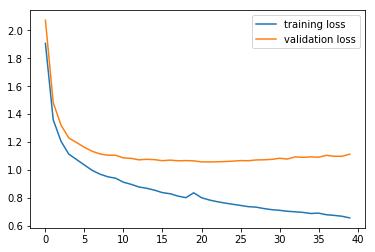

In [14]:
model = BeatlesLSTM(64, 1)
train_losses_1h, val_losses_1h = train_loop(
        model, 40, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_2_beatles_h64s_1layer_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_1h))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h, label='training loss')
plt.plot(ts, val_losses_1h, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.276262
	validation loss = 2.434748
on epoch 1
	on iteration 14 / 15
	training loss = 2.327072
	validation loss = 2.506306
on epoch 2
	on iteration 14 / 15
	training loss = 2.292463
	validation loss = 2.410080
on epoch 3
	on iteration 14 / 15
	training loss = 2.755445
	validation loss = 2.846961
on epoch 4
	on iteration 14 / 15
	training loss = 1.542633
	validation loss = 1.681218
on epoch 5
	on iteration 14 / 15
	training loss = 1.434209
	validation loss = 1.565294
on epoch 6
	on iteration 14 / 15
	training loss = 1.328175
	validation loss = 1.455222
on epoch 7
	on iteration 14 / 15
	training loss = 1.252651
	validation loss = 1.375383
on epoch 8
	on iteration 14 / 15
	training loss = 1.196936
	validation loss = 1.318019
on epoch 9
	on iteration 14 / 15
	training loss = 1.165550
	validation loss = 1.283998
on epoch 10
	on iteration 14 / 15
	training loss = 1.124590
	validation loss = 1.247057
on epoch 11
	on iteration 14 / 15
	trainin

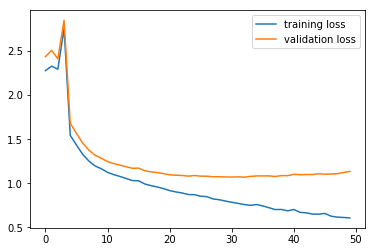

In [16]:
model = BeatlesLSTM(64, 2)
train_losses_2h, val_losses_2h = train_loop(
        model, 50, train_data_ix, train_data_array, val_data_ix, val_data_array,
        checkpoint_name='model_checkpoint_2_beatles_h64s_2layer_mb4_epoch', minibatch_size=4)
ts = np.arange(len(train_losses_2h))
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h, label='training loss')
plt.plot(ts, val_losses_2h, label='validation loss')
plt.legend(loc='best')
plt.show()

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 1.187812
	validation loss = 1.348848
on epoch 1
	on iteration 14 / 15
	training loss = 1.022788
	validation loss = 1.203534
on epoch 2
	on iteration 14 / 15
	training loss = 0.935270
	validation loss = 1.131024
on epoch 3
	on iteration 14 / 15
	training loss = 0.884417
	validation loss = 1.095488
on epoch 4
	on iteration 14 / 15
	training loss = 0.850488
	validation loss = 1.077793
on epoch 5
	on iteration 14 / 15
	training loss = 0.822790
	validation loss = 1.066575
on epoch 6
	on iteration 14 / 15
	training loss = 0.800705
	validation loss = 1.059538
on epoch 7
	on iteration 14 / 15
	training loss = 0.781017
	validation loss = 1.054191
on epoch 8
	on iteration 14 / 15
	training loss = 0.762980
	validation loss = 1.050727
on epoch 9
	on iteration 14 / 15
	training loss = 0.747568
	validation loss = 1.049325
on epoch 10
	on iteration 14 / 15
	training loss = 0.732196
	validation loss = 1.047841
on epoch 11
	on i

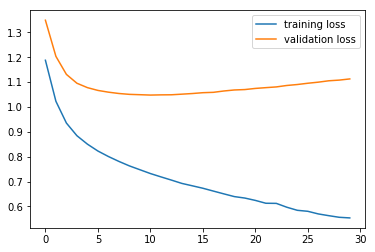

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.466638
	validation loss = 1.643668
on epoch 1
	on iteration 14 / 15
	training loss = 1.303706
	validation loss = 1.476636
on epoch 2
	on iteration 14 / 15
	training loss = 1.213663
	validation loss = 1.385523
on epoch 3
	on iteration 14 / 15
	training loss = 1.161263
	validation loss = 1.337489
on epoch 4
	on iteration 14 / 15
	training loss = 1.128609
	validation loss = 1.310037
on epoch 5
	on iteration 14 / 15
	training loss = 1.103801
	validation loss = 1.290590
on epoch 6
	on iteration 14 / 15
	training loss = 1.083062
	validation loss = 1.275477
on epoch 7
	on iteration 14 / 15
	training loss = 1.064951
	validation loss = 1.263080
on epoch 8
	on iteration 14 / 15
	training loss = 1.048675
	validation loss = 1.252574
on epoch 9
	on iteration 14 / 15
	training loss = 1.033716
	validation loss = 1.243513
on epoch 10
	on iteration 14 / 15
	training loss = 1.019878
	validation loss = 1.235621
on epoch 11
	on i

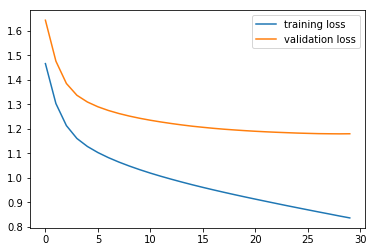

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 2.760766
	validation loss = 2.839868
on epoch 1
	on iteration 14 / 15
	training loss = 1.346402
	validation loss = 1.545520
on epoch 2
	on iteration 14 / 15
	training loss = 1.182669
	validation loss = 1.382021
on epoch 3
	on iteration 14 / 15
	training loss = 1.078659
	validation loss = 1.279917
on epoch 4
	on iteration 14 / 15
	training loss = 1.015355
	validation loss = 1.221483
on epoch 5
	on iteration 14 / 15
	training loss = 0.978423
	validation loss = 1.191850
on epoch 6
	on iteration 14 / 15
	training loss = 0.948647
	validation loss = 1.171566
on epoch 7
	on iteration 14 / 15
	training loss = 0.924097
	validation loss = 1.155169
on epoch 8
	on iteration 14 / 15
	training loss = 0.902842
	validation loss = 1.141342
on epoch 9
	on iteration 14 / 15
	training loss = 0.883862
	validation loss = 1.130337
on epoch 10
	on iteration 14 / 15
	training loss = 0.866641
	validation loss = 1.120502
on epoch 11
	on i

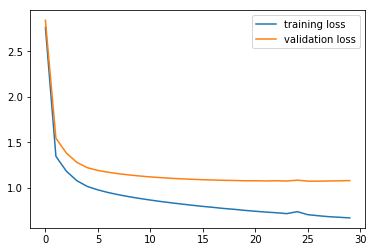

In [17]:
epochs = 30
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training all but layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_2_h64_3layer_epoch50'))
    freeze_layer(gutenberg_model, l)

    gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix, val_data_array)
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

training all but layer 0
on epoch 0
	on iteration 14 / 15
	training loss = 1.245900
	validation loss = 1.386737
on epoch 1
	on iteration 14 / 15
	training loss = 1.137052
	validation loss = 1.273558
on epoch 2
	on iteration 14 / 15
	training loss = 1.067435
	validation loss = 1.200886
on epoch 3
	on iteration 14 / 15
	training loss = 1.025295
	validation loss = 1.156439
on epoch 4
	on iteration 14 / 15
	training loss = 0.996801
	validation loss = 1.128440
on epoch 5
	on iteration 14 / 15
	training loss = 0.976921
	validation loss = 1.110723
on epoch 6
	on iteration 14 / 15
	training loss = 0.958726
	validation loss = 1.095518
on epoch 7
	on iteration 14 / 15
	training loss = 0.945804
	validation loss = 1.084888
on epoch 8
	on iteration 14 / 15
	training loss = 0.933536
	validation loss = 1.075399
on epoch 9
	on iteration 14 / 15
	training loss = 0.924319
	validation loss = 1.068853
on epoch 10
	on iteration 14 / 15
	training loss = 0.914900
	validation loss = 1.061671
on epoch 11
	on i

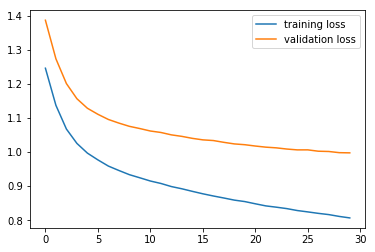

training all but layer 1
on epoch 0
	on iteration 14 / 15
	training loss = 1.427841
	validation loss = 1.588632
on epoch 1
	on iteration 14 / 15
	training loss = 1.255011
	validation loss = 1.392311
on epoch 2
	on iteration 14 / 15
	training loss = 1.192842
	validation loss = 1.323145
on epoch 3
	on iteration 14 / 15
	training loss = 1.162960
	validation loss = 1.292125
on epoch 4
	on iteration 14 / 15
	training loss = 1.142022
	validation loss = 1.272131
on epoch 5
	on iteration 14 / 15
	training loss = 1.126190
	validation loss = 1.256853
on epoch 6
	on iteration 14 / 15
	training loss = 1.114459
	validation loss = 1.244988
on epoch 7
	on iteration 14 / 15
	training loss = 1.102873
	validation loss = 1.234457
on epoch 8
	on iteration 14 / 15
	training loss = 1.092527
	validation loss = 1.224661
on epoch 9
	on iteration 14 / 15
	training loss = 1.082582
	validation loss = 1.215508
on epoch 10
	on iteration 14 / 15
	training loss = 1.073972
	validation loss = 1.207789
on epoch 11
	on i

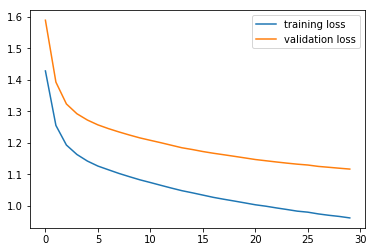

training all but layer 2
on epoch 0
	on iteration 14 / 15
	training loss = 1.849014
	validation loss = 1.993582
on epoch 1
	on iteration 14 / 15
	training loss = 1.303348
	validation loss = 1.468480
on epoch 2
	on iteration 14 / 15
	training loss = 1.177535
	validation loss = 1.331514
on epoch 3
	on iteration 14 / 15
	training loss = 1.107613
	validation loss = 1.255592
on epoch 4
	on iteration 14 / 15
	training loss = 1.070719
	validation loss = 1.217231
on epoch 5
	on iteration 9 / 15

In [ ]:
epochs = 30
layers = [0, 1, 2]
gt_losses = np.zeros((len(layers), epochs))
gv_losses = np.zeros((len(layers), epochs))
for l, enabled_layer in enumerate(layers):
    print('training all but layer %d' % l)
    gutenberg_model = BeatlesLSTM(64, 3)
    gutenberg_model.load_state_dict(torch.load('model_checkpoint_2_h64_3layer_epoch50'))
    gutenberg_model.lstm.dropout = 0.2
    freeze_layer(gutenberg_model, l)

    gt_losses[l], gv_losses[l] = train_loop(gutenberg_model, epochs, train_data_ix, train_data_array, val_data_ix, val_data_array)
    
    ts = np.arange(epochs)
    print('min val_loss is %f, after epoch %d' % (np.min(gv_losses[l]), np.argmin(gv_losses[l])))
    plt.plot(ts, gt_losses[l], label='training loss')
    plt.plot(ts, gv_losses[l], label='validation loss')
    plt.legend(loc='best')
    plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.032823
	validation loss = 2.155854
on epoch 1
	on iteration 14 / 15
	training loss = 1.626798
	validation loss = 1.781744
on epoch 2
	on iteration 14 / 15
	training loss = 1.271204
	validation loss = 1.397018
on epoch 3
	on iteration 14 / 15
	training loss = 1.170180
	validation loss = 1.293801
on epoch 4
	on iteration 14 / 15
	training loss = 1.119799
	validation loss = 1.239029
on epoch 5
	on iteration 14 / 15
	training loss = 1.088351
	validation loss = 1.212669
on epoch 6
	on iteration 14 / 15
	training loss = 1.045745
	validation loss = 1.169265
on epoch 7
	on iteration 14 / 15
	training loss = 1.019204
	validation loss = 1.146693
on epoch 8
	on iteration 14 / 15
	training loss = 0.997360
	validation loss = 1.127026
on epoch 9
	on iteration 14 / 15
	training loss = 0.980056
	validation loss = 1.114606
on epoch 10
	on iteration 14 / 15
	training loss = 0.961726
	validation loss = 1.100636
on epoch 11
	on iteration 14 / 15
	trainin

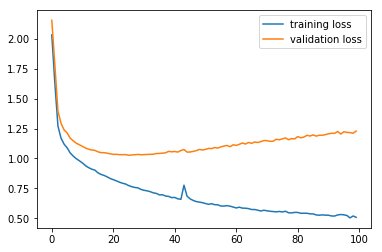

on epoch 0
	on iteration 14 / 15
	training loss = 2.317505
	validation loss = 2.508840
on epoch 1
	on iteration 14 / 15
	training loss = 2.264083
	validation loss = 2.435805
on epoch 2
	on iteration 14 / 15
	training loss = 2.531148
	validation loss = 2.640087
on epoch 3
	on iteration 14 / 15
	training loss = 2.151304
	validation loss = 2.310734
on epoch 4
	on iteration 14 / 15
	training loss = 1.601551
	validation loss = 1.760610
on epoch 5
	on iteration 14 / 15
	training loss = 1.564703
	validation loss = 1.720472
on epoch 6
	on iteration 14 / 15
	training loss = 1.503136
	validation loss = 1.650919
on epoch 7
	on iteration 14 / 15
	training loss = 1.441583
	validation loss = 1.583103
on epoch 8
	on iteration 14 / 15
	training loss = 1.400141
	validation loss = 1.538993
on epoch 9
	on iteration 14 / 15
	training loss = 1.336767
	validation loss = 1.472117
on epoch 10
	on iteration 14 / 15
	training loss = 1.288506
	validation loss = 1.423674
on epoch 11
	on iteration 14 / 15
	trainin

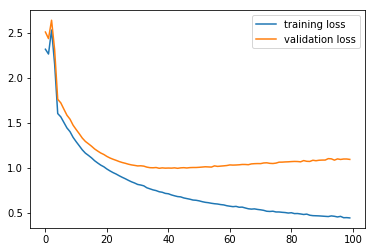

on epoch 0
	on iteration 14 / 15
	training loss = 2.269698
	validation loss = 2.443218
on epoch 1
	on iteration 14 / 15
	training loss = 2.267279
	validation loss = 2.450961
on epoch 2
	on iteration 14 / 15
	training loss = 2.220295
	validation loss = 2.385560
on epoch 3
	on iteration 14 / 15
	training loss = 2.148806
	validation loss = 2.329674
on epoch 4
	on iteration 14 / 15
	training loss = 2.070253
	validation loss = 2.254441
on epoch 5
	on iteration 14 / 15
	training loss = 2.002665
	validation loss = 2.184605
on epoch 6
	on iteration 14 / 15
	training loss = 2.010509
	validation loss = 2.213060
on epoch 7
	on iteration 14 / 15
	training loss = 1.929001
	validation loss = 2.136834
on epoch 8
	on iteration 14 / 15
	training loss = 1.899246
	validation loss = 2.098839
on epoch 9
	on iteration 14 / 15
	training loss = 1.898453
	validation loss = 2.122300
on epoch 10
	on iteration 14 / 15
	training loss = 1.887836
	validation loss = 2.118279
on epoch 11
	on iteration 14 / 15
	trainin

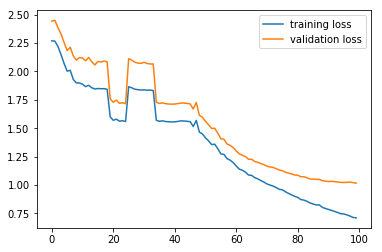

In [86]:


for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_1h_dropout += [train_loss]
    val_losses_1h_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_1layer_dropout_mb4_epoch' + str(epoch))

ts = np.arange(100)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_1h), np.argmin(val_losses_1h)))
plt.plot(ts, train_losses_1h_dropout, label='training loss')
plt.plot(ts, val_losses_1h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

#######################################

model = BeatlesLSTM(64, 2)
model.lstm.dropout = 0.2
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_2h_dropout = []
val_losses_2h_dropout = []
minibatch_size = 4

for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_2h_dropout += [train_loss]
    val_losses_2h_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_2layer_dropout_mb4_epoch' + str(epoch))

ts = np.arange(100)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_2h), np.argmin(val_losses_2h)))
plt.plot(ts, train_losses_2h_dropout, label='training loss')
plt.plot(ts, val_losses_2h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

########################################

model = BeatlesLSTM(64, 3)
model.lstm.dropout = 0.2
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h_dropout = []
val_losses_3h_dropout = []
minibatch_size = 4

for epoch in range(100):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h_dropout += [train_loss]
    val_losses_3h_dropout += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_dropout_mb4_epoch' + str(epoch))

ts = np.arange(100)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h_dropout, label='training loss')
plt.plot(ts, val_losses_3h_dropout, label='validation loss')
plt.legend(loc='best')
plt.show()

on epoch 0
	on iteration 14 / 15
	training loss = 2.267184
	validation loss = 2.438525
on epoch 1
	on iteration 14 / 15
	training loss = 2.261115
	validation loss = 2.431079
on epoch 2
	on iteration 14 / 15
	training loss = 2.248105
	validation loss = 2.414086
on epoch 3
	on iteration 14 / 15
	training loss = 2.254474
	validation loss = 2.423222
on epoch 4
	on iteration 14 / 15
	training loss = 2.398250
	validation loss = 2.620334
on epoch 5
	on iteration 14 / 15
	training loss = 2.259781
	validation loss = 2.425845
on epoch 6
	on iteration 14 / 15
	training loss = 2.254587
	validation loss = 2.425535
on epoch 7
	on iteration 14 / 15
	training loss = 1.613242
	validation loss = 1.771025
on epoch 8
	on iteration 14 / 15
	training loss = 1.581174
	validation loss = 1.767301
on epoch 9
	on iteration 14 / 15
	training loss = 1.567174
	validation loss = 1.723370
on epoch 10
	on iteration 14 / 15
	training loss = 1.551507
	validation loss = 1.706267
on epoch 11
	on iteration 14 / 15
	trainin

	on iteration 14 / 15
	training loss = 0.505220
	validation loss = 1.349303
on epoch 186
	on iteration 14 / 15
	training loss = 0.505909
	validation loss = 1.336979
on epoch 187
	on iteration 14 / 15
	training loss = 0.501727
	validation loss = 1.366570
on epoch 188
	on iteration 14 / 15
	training loss = 0.501023
	validation loss = 1.345570
on epoch 189
	on iteration 14 / 15
	training loss = 0.501371
	validation loss = 1.367195
on epoch 190
	on iteration 14 / 15
	training loss = 0.506346
	validation loss = 1.352682
on epoch 191
	on iteration 14 / 15
	training loss = 0.492062
	validation loss = 1.366562
on epoch 192
	on iteration 14 / 15
	training loss = 0.489767
	validation loss = 1.358472
on epoch 193
	on iteration 14 / 15
	training loss = 0.524931
	validation loss = 1.374461
on epoch 194
	on iteration 14 / 15
	training loss = 0.526192
	validation loss = 1.387042
on epoch 195
	on iteration 14 / 15
	training loss = 0.487958
	validation loss = 1.368690
on epoch 196
	on iteration 14 / 15

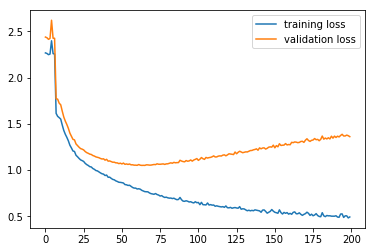

on epoch 0
	on iteration 14 / 15
	training loss = 2.272050
	validation loss = 2.447581
on epoch 1
	on iteration 14 / 15
	training loss = 2.259292
	validation loss = 2.432505
on epoch 2
	on iteration 14 / 15
	training loss = 2.221035
	validation loss = 2.372898
on epoch 3
	on iteration 14 / 15
	training loss = 2.324769
	validation loss = 2.528704
on epoch 4
	on iteration 14 / 15
	training loss = 1.666363
	validation loss = 1.825248
on epoch 5
	on iteration 14 / 15
	training loss = 1.596335
	validation loss = 1.753786
on epoch 6
	on iteration 14 / 15
	training loss = 1.561754
	validation loss = 1.717473
on epoch 7
	on iteration 14 / 15
	training loss = 1.500441
	validation loss = 1.651399
on epoch 8
	on iteration 14 / 15
	training loss = 3.273242
	validation loss = 3.272905
on epoch 9
	on iteration 14 / 15
	training loss = 1.533639
	validation loss = 1.686919
on epoch 10
	on iteration 14 / 15
	training loss = 1.446497
	validation loss = 1.592998
on epoch 11
	on iteration 14 / 15
	trainin

	on iteration 14 / 15
	training loss = 0.274836
	validation loss = 1.843447
on epoch 186
	on iteration 14 / 15
	training loss = 0.300762
	validation loss = 1.759373
on epoch 187
	on iteration 14 / 15
	training loss = 0.295800
	validation loss = 1.743596
on epoch 188
	on iteration 14 / 15
	training loss = 0.231364
	validation loss = 1.786656
on epoch 189
	on iteration 14 / 15
	training loss = 0.256015
	validation loss = 1.780469
on epoch 190
	on iteration 14 / 15
	training loss = 0.245000
	validation loss = 1.798954
on epoch 191
	on iteration 14 / 15
	training loss = 0.284667
	validation loss = 1.818078
on epoch 192
	on iteration 14 / 15
	training loss = 0.322807
	validation loss = 1.774171
on epoch 193
	on iteration 14 / 15
	training loss = 0.255936
	validation loss = 1.785370
on epoch 194
	on iteration 14 / 15
	training loss = 0.221774
	validation loss = 1.790773
on epoch 195
	on iteration 14 / 15
	training loss = 0.214051
	validation loss = 1.829525
on epoch 196
	on iteration 14 / 15

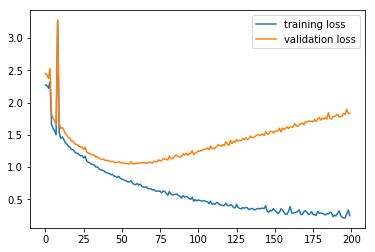

In [81]:
# the 3-deep stacks looked like they could have used some more training. Let's train them for 200 epochs.

model = BeatlesLSTM(32, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h_32 = []
val_losses_3h_32 = []
minibatch_size = 4

for epoch in range(200):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h_32 += [train_loss]
    val_losses_3h_32 += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h32s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(200)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h_32, label='training loss')
plt.plot(ts, val_losses_3h_32, label='validation loss')
plt.legend(loc='best')
plt.show()

######################################

model = BeatlesLSTM(64, 3)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters())

train_losses_3h = []
val_losses_3h = []
minibatch_size = 4

for epoch in range(200):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    train_losses_3h += [train_loss]
    val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

ts = np.arange(200)
print('min val_loss is %f, after timestep %d' % (np.min(val_losses_3h), np.argmin(val_losses_3h)))
plt.plot(ts, train_losses_3h, label='training loss')
plt.plot(ts, val_losses_3h, label='validation loss')
plt.legend(loc='best')
plt.show()

In [60]:
softmax = torch.nn.Softmax()
chars = range(128)

def sample_char(char_scores, temp):
    char_scores = softmax(char_scores / temp)
    char = np.random.choice(chars, p=char_scores.detach().numpy())
    while not chr(char) in string.printable and char != 0:
        char = np.random.choice(chars, p=char_scores.detach().numpy())
    return char

def sample(model, first_char, init_hidden, T, temp):
    model.init_hidden_zeros(1)
    result = first_char
    cur_char = ord(first_char)
    for t in range(T):
        one_hot_char = torch.tensor(i128[cur_char], dtype=torch.float).view(1, 1, -1)
        char_scores = model(one_hot_char)
        cur_char = sample_char(char_scores.view(-1), temp)
        if cur_char == 0:
            return result
        result += chr(cur_char)
    return result

sampled_song = sample(model, '\\', torch.zeros((1, 1, model.hidden_dim)), 500, 0.5).replace('\\n', '\n')
print(sampled_song)

/home/alex/bin/anaconda3/envs/cs682/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """



For the sand all to see it abopt me.

I dont lat a do.
Some me be me the some it a man the mard the say
Its what I want)
She good it want of near bele to the mand the mo.
You know I love it's it all the slead,
If you know I love me

Somed Im the some loverstreed the girl
Its the mind it bebely Fielly don't here with you,
You know the some foot en the way
I want to pleave me

I find me.

I say the song to be you say the man the fear.




In [84]:
gutenberg_model = BeatlesLSTM(64, 3)
gutenberg_model.load_state_dict(torch.load('model_checkpoint_2_h64_3layer_epoch50'))
print('loss of best Gutenberg LSTM on Beatles validation data is %f' % model_loss(gutenberg_model, loss_func, val_data_ix, val_data_array))

minibatch_size = 4

loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.RMSprop(gutenberg_model.parameters())

for epoch in range(200):
    print('on epoch %d' % epoch)
    for i in range((train_data_ix.shape[1] + 1) // minibatch_size):
        print('\r\ton iteration %d / %d' % (i, (train_data_ix.shape[1] + 1) // minibatch_size), end='')
        gutenberg_model.zero_grad()
        
        sequence_in = train_data_ix[:-1, i * minibatch_size : (i + 1) * minibatch_size, :]
        sequence_out = train_data_array[1:, i * minibatch_size : (i + 1) * minibatch_size]
        
        # the last minibatch might have a different size if minibatch_size doesn't evenly divide the number of songs
        this_minibatch_size = sequence_in.shape[1]
        gutenberg_model.init_hidden_zeros(this_minibatch_size)
        
        char_scores = gutenberg_model(sequence_in)
        loss = loss_func(char_scores.contiguous().view(-1, char_dim), sequence_out.contiguous().view(-1))
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(gutenberg_model.parameters(), 5)
        optimizer.step()
    print()
    train_loss = model_loss(gutenberg_model, loss_func, train_data_ix, train_data_array)
    val_loss = model_loss(gutenberg_model, loss_func, val_data_ix, val_data_array)
    print('\ttraining loss = %f' % train_loss)
    print('\tvalidation loss = %f' % val_loss)
    #train_losses_3h += [train_loss]
    #val_losses_3h += [val_loss]
    torch.save(model.state_dict(), 'model_checkpoint_beatles_h64s_3layer_mb4_epoch' + str(epoch))

loss of best Gutenberg LSTM on Beatles validation data is 11.861580
on epoch 0
	on iteration 14 / 15
	training loss = 1.049871
	validation loss = 1.194293
on epoch 1
	on iteration 14 / 15
	training loss = 0.917023
	validation loss = 1.078366
on epoch 2
	on iteration 14 / 15
	training loss = 0.855619
	validation loss = 1.034004
on epoch 3
	on iteration 14 / 15
	training loss = 0.815328
	validation loss = 1.008193
on epoch 4
	on iteration 14 / 15
	training loss = 0.786037
	validation loss = 0.992822
on epoch 5
	on iteration 14 / 15
	training loss = 0.761784
	validation loss = 0.982182
on epoch 6
	on iteration 14 / 15
	training loss = 0.741227
	validation loss = 0.974579
on epoch 7
	on iteration 14 / 15
	training loss = 0.722647
	validation loss = 0.969144
on epoch 8
	on iteration 14 / 15
	training loss = 0.705638
	validation loss = 0.965375
on epoch 9
	on iteration 14 / 15
	training loss = 0.689736
	validation loss = 0.963225
on epoch 10
	on iteration 14 / 15
	training loss = 0.674946
	v

KeyboardInterrupt: 